# Pneumonia Detection on Chest X-rays - Building and Training the Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
import scipy
import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of the metadata for easier model training:

In [2]:
## Code to read all of the full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
112004,00030725_000.png,No Finding,0,30725,71,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030725_000.png
85802,00021173_002.png,No Finding,2,21173,54,F,PA,2048,2500,0.168000,0.168000,NaN,/data/images_010/images/00021173_002.png
69174,00017069_000.png,No Finding,0,17069,52,M,AP,3056,2544,0.139000,0.139000,NaN,/data/images_008/images/00017069_000.png


In [3]:
## Create some extra columns in the table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head(4)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['Pneumonia Class'] = all_xray_df['Pneumonia'].map(lambda finding: 1.0 if finding == 1.0 else 0)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
all_xray_df.loc[all_xray_df['Pneumonia'] == 1.0]
all_xray_df['Pneumonia Class'].value_counts()#/len(all_xray_df)


0.0    110689
1.0      1431
Name: Pneumonia Class, dtype: int64

## Create the training and testing data:

In [6]:
def create_splits(df):
    
    ## Use a sci-kit learn built-in library to split the original dataframe into two sets 
    ## that can be used for training and testing the model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    ## split the dataset's POSITIVE cases- 80, 20
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia Class'])
    
    ## check how our data is split
    print("POSITIVE PNEUM. CASES SPLIT")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    
    ## throw away some data from the train_data set so that we 
    ## have equal proportions of cases with and without pneumonia
    pneum_inds = train_data[train_data['Pneumonia Class'] == 1].index.tolist()
    no_pneum_inds = train_data[train_data['Pneumonia Class'] == 0].index.tolist()
    
    no_pneum_sample = sample(no_pneum_inds, len(pneum_inds))
    train_data = train_data.loc[pneum_inds + no_pneum_sample]
    
    ## check how our data is split
    print("TRAINING SET BALANCED")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    ## balance the validation set so that the set has a 20-80% proportion
    ## 20% pneumonia positive and 80% negative for pneumonia to reflect the
    ## real-world imbalance 
    p_inds = val_data[val_data['Pneumonia Class'] == 1].index.tolist()
    np_inds = val_data[val_data['Pneumonia Class'] == 0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    print("VAL. SET BALANCED")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(all_xray_df)

POSITIVE PNEUM. CASES SPLIT
89696
0.0    88551
1.0     1145
Name: Pneumonia Class, dtype: int64
22424
0.0    22138
1.0      286
Name: Pneumonia Class, dtype: int64
TRAINING SET BALANCED
2290
0.0    1145
1.0    1145
Name: Pneumonia Class, dtype: int64
22424
0.0    22138
1.0      286
Name: Pneumonia Class, dtype: int64
VAL. SET BALANCED
2290
0.0    1145
1.0    1145
Name: Pneumonia Class, dtype: int64
1430
0.0    1144
1.0     286
Name: Pneumonia Class, dtype: int64


In [8]:
len(train_df)

2290

In [9]:
len(val_df)

1430

In [10]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [11]:
val_df['Pneumonia'].sum()/len(val_df)

0.2

# Now we can begin our model-building & training

#### First: perform some image augmentation on the data

In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale = 1.0/255.0,
                                horizontal_flip = False, 
                                vertical_flip = False,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1, 
                                rotation_range = 20, #rotate by a 20 degree angle
                                shear_range = 0.1,
                                zoom_range = 0.1
                               )
    
    return my_idg


def make_train_gen(train_df, IMG_SIZE = (224,224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation()   
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia Class',
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = 229
                                         )

    return train_gen

## do not augment validation data - only rescale
def make_val_gen(val_df, IMG_SIZE = (224,224)):
    my_val_idg = ImageDataGenerator(rescale = 1.0/255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'Pneumonia Class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 65
                                            ) 
    
    return val_gen


In [13]:
## modfiy Pneumonia Class column so values are of string type 
## inorder to use class_mode = 'binary' in creating our training and validation gens
train_df['Pneumonia Class'] = train_df['Pneumonia Class'].astype('str')
val_df['Pneumonia Class'] = val_df['Pneumonia Class'].astype('str')

In [14]:
train_df['path']

4703      /data/images_001/images/00001255_031.png
105806    /data/images_012/images/00028485_005.png
89844     /data/images_010/images/00022310_006.png
59946     /data/images_007/images/00014798_005.png
40091     /data/images_005/images/00010471_001.png
                            ...                   
416       /data/images_001/images/00000103_007.png
79311     /data/images_009/images/00019475_007.png
25387     /data/images_004/images/00006679_012.png
108547    /data/images_012/images/00029445_001.png
88430     /data/images_010/images/00021892_000.png
Name: path, Length: 2290, dtype: object

In [15]:
## create our augmented image training and validation datasets
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

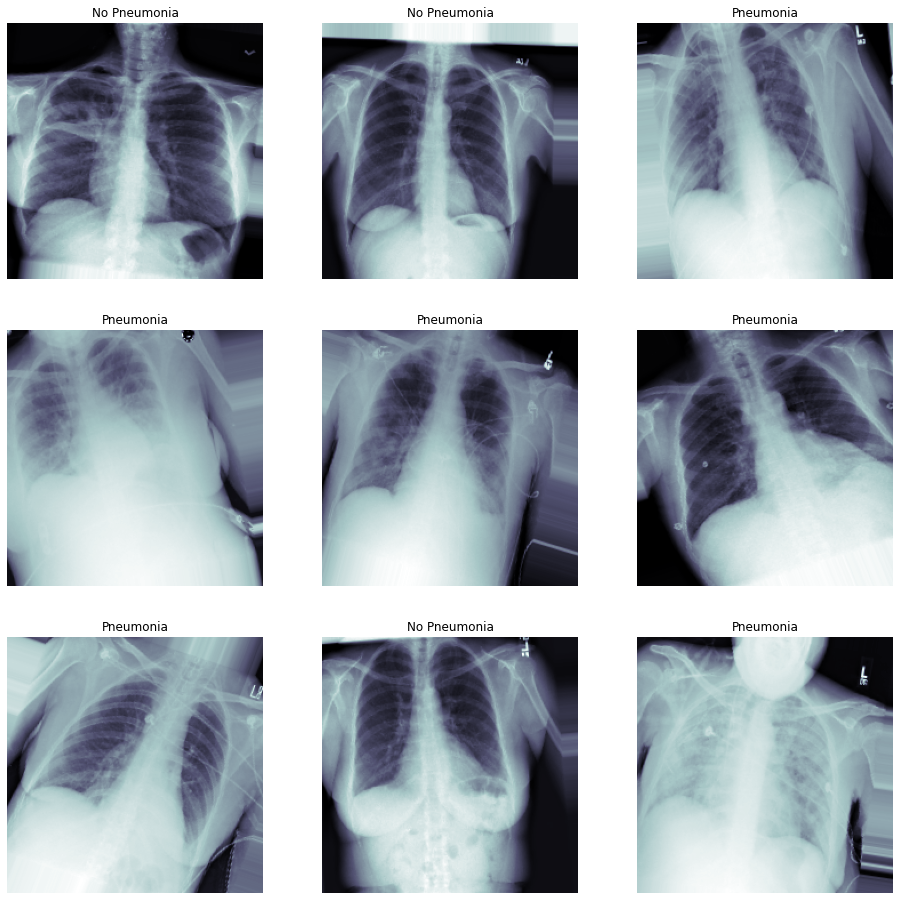

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

## The following code only displays 9 images out of 65 images(1 batch)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


## Building the model: 

Use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool') #include all convolutional layers of vgg16 model
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
#     vgg_model.summary() #vgg_model only consists of the convolutional layers (up to block5_pool) & no dense layers
                        #since we set outputs in Model() to be the last convolutional layer, excluding the dense, fully connected layers
                        #it is our job to implement the appropriate combination of dense layers and drop out
                        #along with activation functions to optimize our model
    
    return vgg_model


In [19]:
vgg_model = load_pretrained_model()
len(vgg_model.layers)

553467904/553467096 [==============================] - 7s 0us/step


19

In [20]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
def build_my_model():
    
    ## in this function, we set the dense layers for the model, since so far, the model only consists
    ## of convolutional layers that were pretrained on imagenet weights. In order to actually predict results,
    ## we must flatten output, add dense layers, dropout, and set optimizer loss functions, and metrics
    
    # Add the pre-trained model, and then whatever additional layers for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # Finally, we set the optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    
    ## freeze conv. layers
    vgg_model = load_pretrained_model()
    ## the following freezes all but the last convolutional layer(block5_conv3)
    ## and consequently, the last pooling layer(block5_pool)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    print(type(vgg_model.layers[1])) 
    ## check that appropriate layers were frozen
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    ## add pretrained model (frozen conv. layers)
    my_model.add(vgg_model)
    
    ## Add three dense layers with dropout (add dropout before each
    ## dense layer, and you add flatten after the frozen conv.layers)
    my_model.add(Flatten())
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation= 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation= 'sigmoid')) # use sigmoid bc we are doing a binary classification (not multiclass)
    
    ## compile model
    my_model.compile(optimizer= Adam(learning_rate = .0007), #1e-4
                     loss = 'binary_crossentropy',
                     metrics = ['binary_accuracy'])
    return my_model

In [22]:
my_model = build_my_model()

<class 'keras.layers.convolutional.Conv2D'>
input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [23]:
## Add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Monitor minimum validation loss as a performance metric
## Model will train for ten epochs without seeing improvement before quitting
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "min",
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [24]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 30, 
                          callbacks = callbacks_list)


Epoch 1/30
10/10 [==============================] - 90s 9s/step - loss: 0.9469 - binary_accuracy: 0.5105 - val_loss: 0.6821 - val_binary_accuracy: 0.7867

Epoch 00001: val_loss improved from inf to 0.68207, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
10/10 [==============================] - 58s 6s/step - loss: 0.7067 - binary_accuracy: 0.5061 - val_loss: 0.6349 - val_binary_accuracy: 0.8000

Epoch 00002: val_loss improved from 0.68207 to 0.63490, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
10/10 [==============================] - 64s 6s/step - loss: 0.6932 - binary_accuracy: 0.5284 - val_loss: 0.6618 - val_binary_accuracy: 0.6531

Epoch 00003: val_loss did not improve from 0.63490
Epoch 4/30
10/10 [==============================] - 64s 6s/step - loss: 0.6887 - binary_accuracy: 0.5594 - val_loss: 0.6750 - val_binary_accuracy: 0.5895

Epoch 00004: val_loss did not improve from 0.63490
Epoch 5/30
10/10 [==============================] - 65s 6s/step - loss: 0.6794

In [48]:
##save model weights to hdf5 file
my_model.save_weights(weight_path)

### Plotting performance statistics:

In [26]:
## After training, make some predictions to assess your model's overall performance
## Since detecting pneumonia is hard even for trained expert radiologists, 
## there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 65, verbose = True)

65/65 [==============================] - 1s 13ms/step


In [41]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    ##CONFIRM WHAT IS MEANT BY 'PLOT' AUC
    roc_auc = auc(fpr,tpr)
    print('AUC is ', roc_auc)
    return

## what other performance statistics do you want to include here besides AUC? 
def plot_roc(true_y,pred_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(true_y, pred_y) 
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return fpr, tpr

def plot_precision_recall_curve(true_y,pred_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(true_y, pred_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(true_y,pred_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds
    
#Also consider plotting the history of your model training:
def plot_history(history):
    
    # set up
    N = len(history.history["loss"])
    fig, (plt_loss, plt_acc) = plt.subplots(1, 2, figsize=(15,10))    
    
    #plot loss and val_loss on one graph
    plt_loss.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt_loss.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt_loss.set_title("Training Loss on Dataset")
    plt_loss.set(xlabel = "Epoch #", ylabel = "Loss")
    plt_loss.legend(loc="lower left")
    
    #plot acc and val_acc on another graph
    plt_acc.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt_acc.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt_acc.set_title("Training Acc on Dataset")
    plt_acc.set(xlabel = "Epoch #", ylabel = "Accuracy")
    plt_acc.legend(loc="lower left")
    
    return

def calculate_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall)

def f1_at_threshold(threshold_val, precision, recall, thresholds, prec_thresh=False, recall_thresh=False):
    ##take a look at the threshold depending on whether
    ##the threshold favors precision or recall
    idx= 0
    if prec_thresh:
        idx = (np.abs(precision - threshold_val)).argmin() 
    if recall_thresh:
        idx = (np.abs(recall - threshold_val)).argmin()
    
    ##print precision, recall, threshold, and f1 score
    f1_score = calculate_f1(precision[idx],recall[idx])
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calculate_f1(precision[idx],recall[idx])))
    
    return f1_score


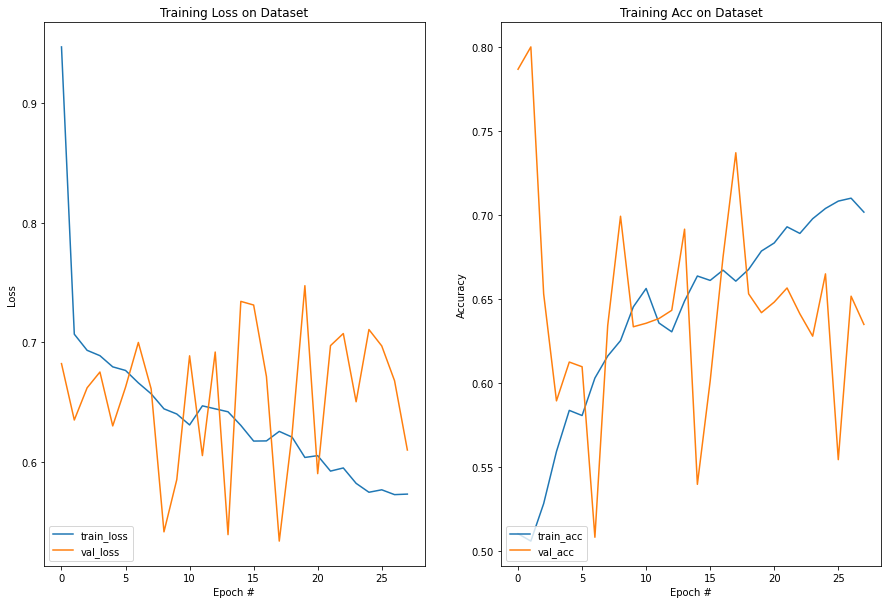

In [28]:
## plot figures
plot_history(history)

(array([0.        , 0.02083333, 0.02083333, 0.10416667, 0.10416667,
        0.125     , 0.125     , 0.14583333, 0.14583333, 0.39583333,
        0.39583333, 0.45833333, 0.45833333, 0.52083333, 0.52083333,
        0.5625    , 0.5625    , 0.72916667, 0.72916667, 0.79166667,
        0.79166667, 0.83333333, 0.83333333, 0.89583333, 0.89583333,
        1.        ]),
 array([0.        , 0.        , 0.11764706, 0.11764706, 0.23529412,
        0.23529412, 0.29411765, 0.29411765, 0.47058824, 0.47058824,
        0.52941176, 0.52941176, 0.58823529, 0.58823529, 0.64705882,
        0.64705882, 0.70588235, 0.70588235, 0.76470588, 0.76470588,
        0.82352941, 0.82352941, 0.88235294, 0.88235294, 1.        ,
        1.        ]))

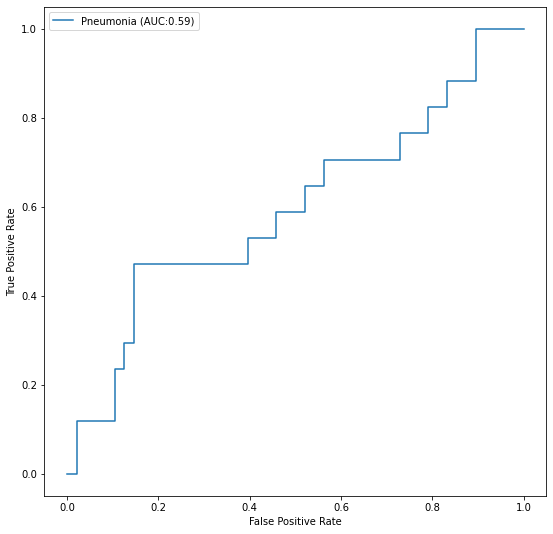

In [29]:
plot_roc(valY, pred_Y)

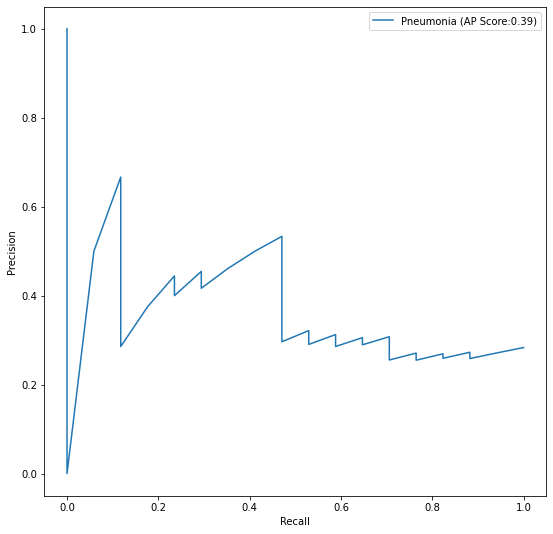

In [30]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)

When finished training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.) 

NOTE: optimize for F1 score as our dataset is imbalanced

In [39]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## pick val for threshold_val, send in precision, recall, thresholds arrays, and declare
## either prec_thres or recall_thresh as true, depending on if you want to
## favor precision or recall

threshold_val = 0.6
f1_at_threshold(threshold_val, precision, recall, thresholds, prec_thresh=True, recall_thresh=False) 

Precision is: 0.5333333333333333
Recall is: 0.47058823529411764
Threshold is: 0.6799643
F1 Score is: 0.5


0.5

No handles with labels found to put in legend.


Text(0, 0.5, 'F1 score')

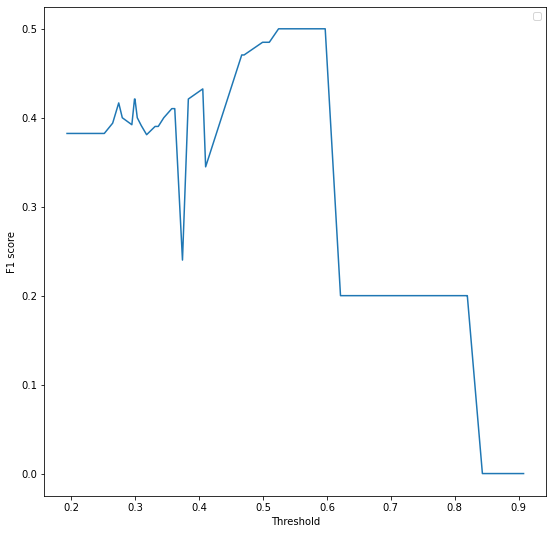

In [42]:
##plotting f1 vs thresholds
f1_scores = []
for thresh_val in thresholds:
    try:
        f1_val = f1_at_threshold(thresh_val, precision, recall, thresholds, prec_thresh=True)
    except IndexError:
        f1_val =0
        
    f1_scores.append(f1_val)
    
fig, ax = plt.subplots(1,1, figsize = (9, 9))
ax.plot(thresholds, f1_scores)
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('F1 score')

True positive:  8
True negative:  41
False negative:  9
False positive:  7


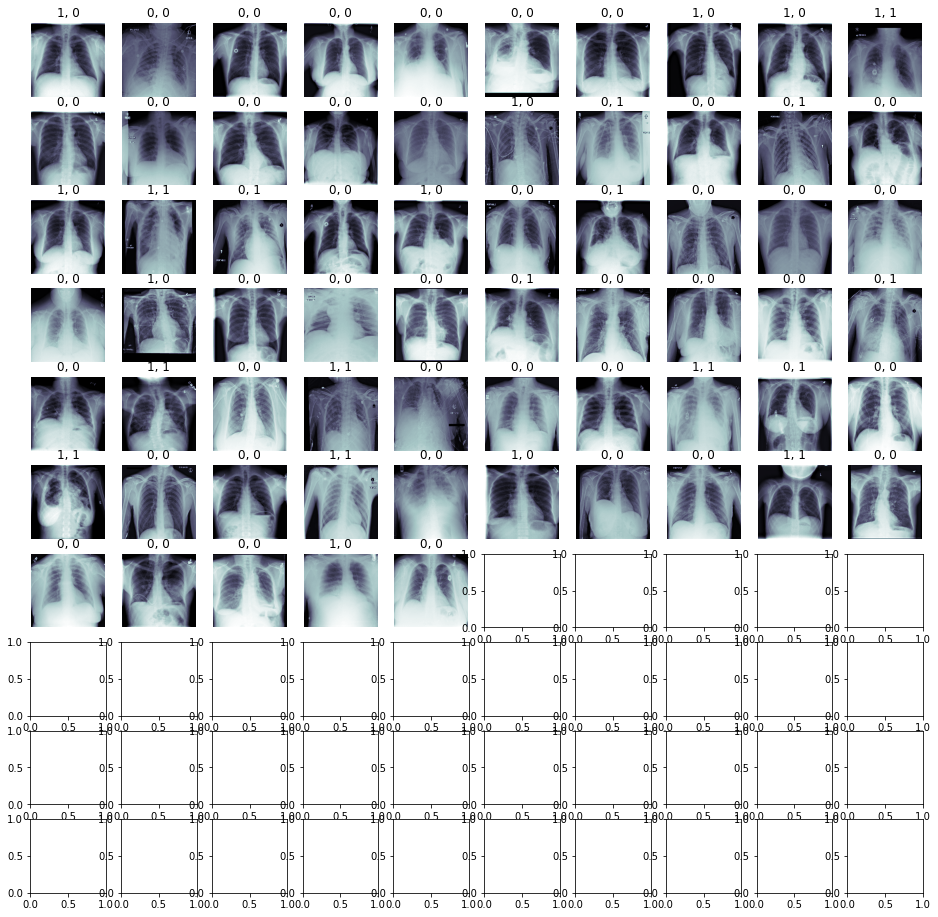

In [46]:
# Let's look at some examples of true vs. predicted with our best model: 
YOUR_THRESHOLD = 0.677
tp = 0
fn = 0
fp = 0
tn = 0


fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1') ## your model correctly predicted a pneumonia xray (true pos)
            tp+=1
        else:
            c_ax.set_title('1, 0') ## your model failed to label an actual pneumonia xray (false neg)
            fn+=1
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1') ## your model predicted a pneumonia in an xray that didnt have it (false postive)
            fp+=1
        else:
            c_ax.set_title('0, 0') ## your model correctly classified an xray without pneumonia (true negative)
            tn+=1
    c_ax.axis('off')
    i=i+1
print("True positive: ", tp)
print("True negative: ", tn)
print("False negative: ", fn)
print("False positive: ", fp)

In [49]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)